In [1]:
import numpy as np
from functools import partial
import old_vis_utils as viz_utils
from iris_plant_visualizer_old import IrisPlantVisualizer
import ipywidgets as widgets
from IPython.display import display

In [2]:
#pydrake imports
import pydrake
from pydrake.common import FindResourceOrThrow
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.framework import DiagramBuilder
from pydrake.geometry import Role, GeometrySet, CollisionFilterDeclaration
from pydrake.solvers import mathematicalprogram as mp
from pydrake.all import RigidTransform, RollPitchYaw, RevoluteJoint

import pydrake.multibody.rational as rational_forward_kinematics
from pydrake.all import RationalForwardKinematics
from pydrake.geometry.optimization import (#IrisOptionsRationalSpace, 
                                           IrisInRationalConfigurationSpace, 
                                           HPolyhedron, 
                                           Hyperellipsoid,
                                           Iris, IrisOptions)
from dijkstraspp import DijkstraSPPsolver  
from visibility_utils import point_in_regions
from pydrake.all import MosekSolver, SolverOptions, CommonSolverOption
# The object we will use to perform our certification.
from pydrake.geometry.optimization_dev import (CspaceFreePolytope,
                                               CIrisSeparatingPlane,
                                               SeparatingPlaneOrder)

<ipython-input-2-418def13bc74>:8: DrakeDeprecationWarning: Please import from the pydrake.solvers module directly, instead of the deprecated pydrake.solvers.mathematicalprogram submodule. The deprecated code will be removed from Drake on or after 2023-05-01.
  from pydrake.solvers import mathematicalprogram as mp


In [3]:
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
parser = Parser(plant)
oneDOF_iiwa_asset = "../../drake/C_Iris_Examples/assets/oneDOF_iiwa7_with_box_collision.sdf"#FindResourceOrThrow("drake/C_Iris_Examples/assets/oneDOF_iiwa7_with_box_collision.sdf")
twoDOF_iiwa_asset = "../../drake/C_Iris_Examples/assets/twoDOF_iiwa7_with_box_collision.sdf"#FindResourceOrThrow("drake/C_Iris_Examples/assets/twoDOF_iiwa7_with_box_collision.sdf")

box_asset = "../../drake/C_Iris_Examples/assets/box_small.urdf" #FindResourceOrThrow("drake/C_Iris_Examples/assets/box_small.urdf")

models = []
models.append(parser.AddModelFromFile(box_asset))
models.append(parser.AddModelFromFile(twoDOF_iiwa_asset))
models.append(parser.AddModelFromFile(oneDOF_iiwa_asset))



locs = [[0.,0.,0.],
        [0.,.55,0.],
        [0.,-.55,0.]]
plant.WeldFrames(plant.world_frame(), 
                 plant.GetFrameByName("base", models[0]),
                 RigidTransform(locs[0]))
plant.WeldFrames(plant.world_frame(), 
                 plant.GetFrameByName("iiwa_twoDOF_link_0", models[1]), 
                 RigidTransform(RollPitchYaw([0,0, -np.pi/2]).ToRotationMatrix(), locs[1]))
plant.WeldFrames(plant.world_frame(), 
                 plant.GetFrameByName("iiwa_oneDOF_link_0", models[2]), 
                 RigidTransform(RollPitchYaw([0,0, -np.pi/2]).ToRotationMatrix(), locs[2]))


plant.Finalize()

idx = 0
q0 = [0.0, 0.0, 0.0]
q_low  = [-1.7, -2., -1.7]
q_high = [ 1.7,  2.,  1.7]
# set the joint limits of the plant
for model in models:
    for joint_index in plant.GetJointIndices(model):
        joint = plant.get_mutable_joint(joint_index)
        if isinstance(joint, RevoluteJoint):
            joint.set_default_angle(q0[idx])
            joint.set_position_limits(lower_limits= np.array([q_low[idx]]), upper_limits= np.array([q_high[idx]]))
            idx += 1
        
# construct the RationalForwardKinematics of this plant. This object handles the
# computations for the forward kinematics in the tangent-configuration space
print(plant)
Ratfk = RationalForwardKinematics(plant)
print(plant)
# the point about which we will take the stereographic projections
q_star = np.zeros(3)

#compute limits in t-space
limits_t = []
for q in [q_low, q_high]:
    limits_t.append(Ratfk.ComputeSValue(np.array(q), q_star))

do_viz = True

# This line builds the visualization. Change the viz_role to Role.kIllustration if you
# want to see the plant with its illustrated geometry or to Role.kProximity
visualizer = IrisPlantVisualizer(plant, builder, scene_graph, viz_role=Role.kIllustration)
diagram = visualizer.diagram

# This line will run marching cubes to generate a mesh of the C-space obstacle
# Increase N to increase the resolution of the C-space obstacle.
visualizer.visualize_collision_constraint(N = 20)



INFO:drake:Meshcat listening for connections at http://localhost:7000
INFO:drake:Meshcat listening for connections at http://localhost:7001
/home/peter/git/drake_visiris_build/drake/C_Iris_Examples/iris_plant_visualizer_old.py:71: DrakeDeprecationWarning: (Deprecated) See ForcedPublish() 
*/ (Deprecated.)

Deprecated:
    Use ForcedPublish() instead This will be removed from Drake on or
    after 2023-03-01.
  self.diagram.Publish(self.diagram_context)


In [4]:
sliders = []
sliders.append(widgets.FloatSlider(min=q_low[0], max=q_high[0], value=0, description='q0'))
sliders.append(widgets.FloatSlider(min=q_low[1], max=q_high[1], value=0, description='q1'))
sliders.append(widgets.FloatSlider(min=q_low[2], max=q_high[2], value=0, description='q2'))

q = q0.copy()
def handle_slider_change(change, idx):
    q[idx] = change['new']
    visualizer.showres(q)
    #visualizer.visualize_planes()
    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

display(sliders[0])
display(sliders[1])
display(sliders[2])

FloatSlider(value=0.0, description='q0', max=1.7, min=-1.7)

FloatSlider(value=0.0, description='q1', max=2.0, min=-2.0)

FloatSlider(value=0.0, description='q2', max=1.7, min=-1.7)

In [5]:
s1 = Ratfk.ComputeSValue(np.array([0.9, -0.9, 0.3]), q_star)
s2 = Ratfk.ComputeSValue(np.array([0.9, -0.9, -1.7]), q_star)


In [6]:
# filter fused joints self collisions so they don't interfere with collision engine
digaram = visualizer.diagram
context = visualizer.diagram_context
plant_context = plant.GetMyMutableContextFromRoot(context)
sg_context = scene_graph.GetMyContextFromRoot(context)
inspector = scene_graph.model_inspector()

pairs = scene_graph.get_query_output_port().Eval(sg_context).inspector().GetCollisionCandidates()

gids = [gid for gid in inspector.GetGeometryIds(GeometrySet(inspector.GetAllGeometryIds()), Role.kProximity)]
get_name_of_gid = lambda gid : inspector.GetName(gid)
gids.sort(key=get_name_of_gid)
iiwa_oneDOF_gids = [gid for gid in gids if "iiwa7_oneDOF::" in get_name_of_gid(gid)]
iiwa_twoDOF_gids = [gid for gid in gids if "iiwa7_twoDOF::" in get_name_of_gid(gid)]

oneDOF_fused_col_geom = iiwa_oneDOF_gids[2:]
iiwa_oneDOF_fused_set = GeometrySet(oneDOF_fused_col_geom)
twoDOF_fused_col_geom = iiwa_twoDOF_gids[4:]
iiwa_twoDOF_fused_set = GeometrySet(twoDOF_fused_col_geom)
scene_graph.collision_filter_manager()\
            .Apply(CollisionFilterDeclaration().ExcludeWithin(iiwa_oneDOF_fused_set))
scene_graph.collision_filter_manager()\
            .Apply(CollisionFilterDeclaration().ExcludeWithin(iiwa_twoDOF_fused_set))

# Setup SNOPT IRIS

In [7]:
domain = HPolyhedron.MakeBox( Ratfk.ComputeSValue(q_low, np.zeros((3,))), Ratfk.ComputeSValue(q_high, np.zeros((3,))))
snopt_iris_options = IrisOptions()
snopt_iris_options.require_sample_point_is_contained = True
snopt_iris_options.iteration_limit = 20
snopt_iris_options.configuration_space_margin = 1e-4
#snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = -1
#snopt_iris_options.q_star = np.zeros(3)
snopt_iris_options.relative_termination_threshold = 0.05

In [8]:

cspace_free_polytope = CspaceFreePolytope(plant, scene_graph,
                                          SeparatingPlaneOrder.kAffine, q_star)
solver_id = MosekSolver.id()

# set up the certifier and the options for different search techniques
solver_options = SolverOptions()
# set this to 1 if you would like to see the solver output in terminal.
solver_options.SetOption(CommonSolverOption.kPrintToConsole, 0)

# The options for when we search for new planes and positivity certificates given the polytopes
find_separation_certificate_given_polytope_options = CspaceFreePolytope.FindSeparationCertificateGivenPolytopeOptions()
find_separation_certificate_given_polytope_options.num_threads = -1
find_separation_certificate_given_polytope_options.verbose = False
find_separation_certificate_given_polytope_options.solver_options = solver_options
find_separation_certificate_given_polytope_options.ignore_redundant_C = False
find_separation_certificate_given_polytope_options.solver_id = solver_id

# The options for when we search for a new polytope given positivity certificates.
find_polytope_given_lagrangian_option = CspaceFreePolytope.FindPolytopeGivenLagrangianOptions()
find_polytope_given_lagrangian_option.solver_options = solver_options
find_polytope_given_lagrangian_option.ellipsoid_margin_cost = CspaceFreePolytope.EllipsoidMarginCost.kGeometricMean
find_polytope_given_lagrangian_option.search_s_bounds_lagrangians = True
find_polytope_given_lagrangian_option.ellipsoid_margin_epsilon = 1e-4
find_polytope_given_lagrangian_option.solver_id = solver_id

# bilinear_alternation_options = CspaceFreePolytope.BilinearAlternationOptions()
# bilinear_alternation_options.max_iter = 10
# bilinear_alternation_options.convergence_tol = 1e-3
# bilinear_alternation_options.find_polytope_options = find_polytope_given_lagrangian_option
# bilinear_alternation_options.find_lagrangian_options = find_separation_certificate_given_polytope_options

binary_search_options = CspaceFreePolytope.BinarySearchOptions()
binary_search_options.find_lagrangian_options = find_separation_certificate_given_polytope_options
binary_search_options.scale_min = 1e-3
binary_search_options.scale_max = 1.1
binary_search_options.max_iter = 6


In [9]:
from tqdm import tqdm
from scipy.sparse import lil_matrix
from visibility_seeding import VisSeeder
from visibility_logging import Logger

# Run Seeding

In [10]:
q_min = np.array(q_low)
q_max = np.array(q_high)
q_diff = q_max-q_min

alpha = 0.05
eps = 0.05
N = 50
seed = 1
np.random.seed(seed)

def estimate_coverage(regions, pts = 3000):
	pts_ = [sample_cfree_SPoint() for _ in range(pts)]
	inreg = 0
	for pt in pts_:
		if point_in_regions(pt, regions): inreg+=1
	return inreg/pts

def sample_cfree_SPoint(MAXIT=100):
	it = 0
	while it<1000:
		rand = np.random.rand(3)
		q_s = q_min + rand*q_diff
		col = False
		for _ in range(10):
			r  = 0.05*(np.random.rand(3)-0.5)
			col |= (visualizer.col_func_handle(q_s+r) > 0)
		if not col:
			return Ratfk.ComputeSValue(q_s, q_star)
		it+=1
	raise ValueError("no col free point found")

def sample_cfree_QPoint_in_regions(regions):
	for _ in range(1000):
		pt = sample_cfree_SPoint()
		if point_in_regions(pt, regions): return Ratfk.ComputeQValue(pt, q_star)
	return None

def sample_cfree_handle(n, m, regions=None):
		points = np.zeros((n,3))
		if regions is None: regions = []		
		for i in range(n):
			bt_tries = 0
			while bt_tries<m:
				point = sample_cfree_SPoint()
				col = False
				for _ in range(10):
					r  = 0.05*(np.random.rand(3)-0.5)
					col |= point_in_regions(point+r, regions)
				if col:
					bt_tries += 1
					if bt_tries == m:
						return points, True 
				else:
					break
			points[i] = point
		return points, False

def vis(t1, t2, regions, num_checks, visualizer):
	t1flat = t1.reshape(-1)
	t2flat = t2.reshape(-1)
	if np.linalg.norm(t1-t2) < 1e-6:
		return (1-visualizer.col_func_handle(Ratfk.ComputeQValue(t1flat, np.zeros(3))))>0
				
	tvec = np.linspace(0,1, num_checks)
	for t in tvec:
		tinterp = t1flat*t + (1-t)*t2flat
		if visualizer.col_func_handle(Ratfk.ComputeQValue(tinterp, np.zeros(3))):
			return False
		elif point_in_regions(tinterp, regions):
			return False
	else:
		return True
    
visibility_checker = partial(vis, num_checks = 40, visualizer = visualizer)

def vgraph_builder(points, regions):
	n = len(points)
	adj_mat = lil_matrix((n,n))
	for i in tqdm(range(n)):
		point = points[i, :]
		for j in range(len(points[:i])):
			other = points[j]
			result = visibility_checker(point, other, regions)
			#print(result)
			if result:
				adj_mat[i,j] = adj_mat[j,i] = 1
	return adj_mat.toarray()


def SNOPT_IRIS(s_seeds,  region_obstacles, plant, context, snoptiris_options, Ratforwardkin):
	regions = []
	for s_seed in s_seeds:
		q_seed = Ratforwardkin.ComputeQValue(s_seed.reshape(-1,1), np.zeros((3,1)))
		#print('snopt iris call')
		snoptiris_options.configuration_obstacles = []
		if len(region_obstacles):
			snopt_iris_options.configuration_obstacles = region_obstacles
		plant.SetPositions(plant.GetMyMutableContextFromRoot(context), q_seed.reshape(-1,1))
		r = IrisInRationalConfigurationSpace(plant, plant.GetMyContextFromRoot(context), q_star, snoptiris_options)
		#run the certifier
		cert = cspace_free_polytope.BinarySearch(set(),
                                        r.A(),
                                        r.b(), 
                                        np.array(s_seed),
                                        binary_search_options)
		regions.append(cert.certified_polytope)
	return regions

SNOPT_IRIS_Handle = partial(SNOPT_IRIS,
                            plant = plant,
                            context = visualizer.diagram_context,
                            snoptiris_options = snopt_iris_options,
                            Ratforwardkin = Ratfk,
                            )


In [11]:
np.random.seed(1)
samples, _ = sample_cfree_handle(200, 30, [])

In [12]:
from pydrake.all import ComputeVisibilityGraph

In [20]:
ad_mat = ComputeVisibilityGraph(samples, plant, plant_context, Ratfk, q_star, 40, 0.0001)

INFO:drake:Remaining Nodes to check 0/200
INFO:drake:Remaining Nodes to check 50/200
INFO:drake:Remaining Nodes to check 100/200
INFO:drake:Remaining Nodes to check 150/200


In [14]:

ad_mat2 = vgraph_builder(samples, [])

100%|██████████| 200/200 [00:48<00:00,  4.10it/s]


In [19]:
np.where(ad_mat2-ad_mat == 1)

(array([ 40,  47,  59,  78,  80,  99, 106, 116, 141, 156, 161, 181]),
 array([141,  78, 106,  47, 156, 116,  59,  99,  40,  80, 181, 161]))

In [19]:
for s in samples:
    print(Ratfk.ComputeQValue(s, q_star))

[ 0.11276197  0.76750846 -0.62724685]
[ 1.17209711  1.62156927 -0.1364071 ]


logdir created
[14:29:13] [VisSeeder] Point Insertion attempts M: 58
[14:29:13] [VisSeeder] 0.95 probability that unseen region is less than 5.0 '%' of Cfree 


100%|██████████| 50/50 [00:03<00:00, 15.52it/s]
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5505 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.82525 is feasible


[14:29:16] [VisSeeder] Found  5  hidden points


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.9626250000000001 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.0313125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.9969687500000001 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.9797968750000001 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5505 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.82525 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.9626250000000001 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.8939375 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.9282812500000001 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.945453125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.5505 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.82525 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.

[14:30:06] [VisSeeder] Bernoulli test failed


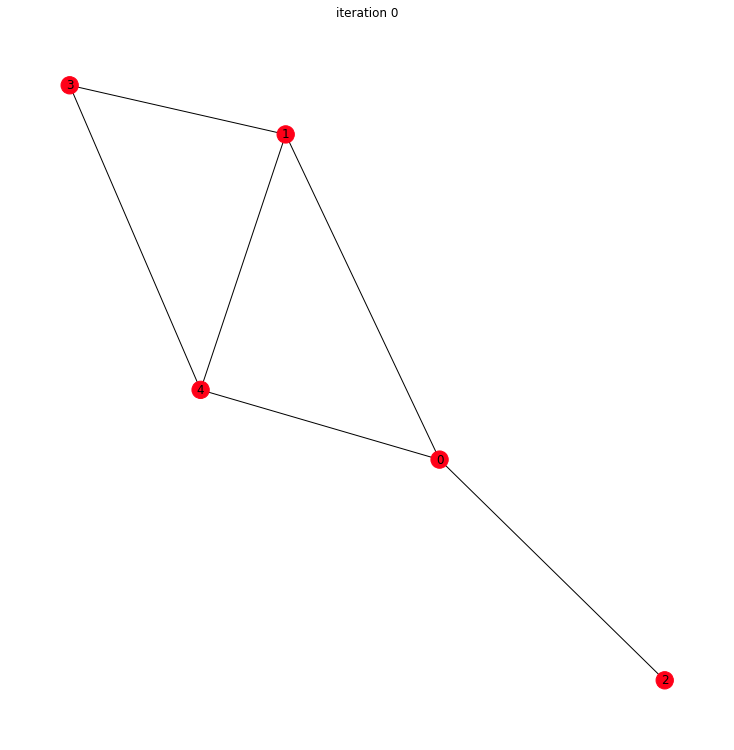

In [ ]:

logger = Logger("3DOf_pinball", seed, N, alpha, eps, estimate_coverage)
VS = VisSeeder(N = N,
            alpha = alpha,
            eps = eps,
            max_iterations = 10,
            sample_cfree = sample_cfree_handle,
            build_vgraph = vgraph_builder,
            iris_w_obstacles = SNOPT_IRIS_Handle,
            verbose = True,
            logger = logger
            )
out = VS.run()

In [ ]:
from  pydrake.all import Rgba
colors = viz_utils.n_colors_random(len(VS.region_groups))
for i, g in enumerate(VS.region_groups):
    visualizer.plot_regions(g, region_suffix=str(i), colors = [colors[i]]*len(g), wireframe=False)

In [ ]:
visualizer.collision_constraint

# Run Pathplanning

In [ ]:
import dijkstraspp
dspp = dijkstraspp.DijkstraSPPsolver(VS.regions, partial(Ratfk.ComputeSValue, q_star_val = np.zeros(3)))


[DijkstraSPP] Pre-Building adjacency matrix  0 / 7


In [ ]:
from pydrake.all import Rgba, Sphere, RotationMatrix
def densify_waypoints(waypoints_t):
    densify = 150
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints_t[:-1])):
        a = waypoints_t[idx]
        b = waypoints_t[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        locs_endeff2 = []
        dists_endeff = []
        for tval in t:
            ta = a*tval + b*(1-tval)
            qa = Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            visualizer.plant.SetPositions(visualizer.plant_context,qa)
            #visualizer.set_joint_angles(qa)
            tf_tot= plant.EvalBodyPoseInWorld(visualizer.plant_context, visualizer.plant.get_body(pydrake.multibody.tree.BodyIndex(12)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
            tf_tot= plant.EvalBodyPoseInWorld(visualizer.plant_context, visualizer.plant.get_body(pydrake.multibody.tree.BodyIndex(20)))
            tf2 = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
            locs_endeff.append(tf)
            locs_endeff2.append(tf2)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(0.5*np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]) + 0.5*np.linalg.norm(locs_endeff2[i]- locs_endeff2[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints_t[idx]*tval + waypoints_t[idx+1]*(1-tval))
    return dense_waypoints

def plot_endeff_traj(dense_waypoints, opt = True):
    color = Rgba(1,0,0,1.0)
    color2 = Rgba(0,0,1,1.0)
    color3 = Rgba(0,1,1,1.0)
    start_idx = 0
    for i, ta in enumerate(dense_waypoints[::2]):
        qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        visualizer.plant.SetPositions(visualizer.plant_context,qa)
        tf_tot= visualizer.plant.EvalBodyPoseInWorld(visualizer.plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(12)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15

        visualizer.meshcat1.SetObject(f"/iris/points/traj/{i+start_idx}",
                               Sphere(0.005),
                               color)

        visualizer.meshcat1.SetTransform(f"/iris/points/traj/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
        
        tf_tot= visualizer.plant.EvalBodyPoseInWorld(visualizer.plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(20)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15

        visualizer.meshcat1.SetObject(f"/iris/points/traj2/{i+start_idx}",
                               Sphere(0.005),
                               color2)

        visualizer.meshcat1.SetTransform(f"/iris/points/traj2/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
        
        visualizer.meshcat2.SetObject(f"/iris/points/traj2/{i+start_idx}",
                               Sphere(0.02),
                               color3)

        visualizer.meshcat2.SetTransform(f"/iris/points/traj2/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  ta))

In [ ]:
import time

start = sample_cfree_QPoint_in_regions(VS.regions)
for _ in range(20):
    #nxt = vs.sample_in_regions() #
    while True:
        nxt = sample_cfree_QPoint_in_regions(VS.regions)
        if nxt[0] != start[0]:
            break
    wp, dist = dspp.solve(start, nxt, refine_path=True)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion, optimize= True)
    print(dist)
    if dist >0:
        dense_waypoints = densify_waypoints(wp)
        plot_endeff_traj(dense_waypoints)
        for ta in dense_waypoints:
            qa = Ratfk.ComputeQValue(ta, np.zeros(3))
            visualizer.showres(qa)
            if visualizer.col_func_handle(qa):
                #print(col)
                break
            time.sleep(0.01)
        start = nxt
        time.sleep(0.1)
        visualizer.meshcat1.Delete("/iris/points/traj/")
        visualizer.meshcat1.Delete("/iris/points/traj2/")
        visualizer.meshcat2.Delete("/iris/points/traj2/")
    else:
        nxt = sample_cfree_QPoint_in_regions(VS.regions)

[DijkstraSPP] optimized distance/ start-distance = 1.25 / 1.44 = 0.87
1.2506512739272133
[DijkstraSPP] optimized distance/ start-distance = 0.69 / 0.92 = 0.75
0.6914966955534263
[DijkstraSPP] optimized distance/ start-distance = 0.31 / 0.31 = 1.00
0.3086938627780342
[DijkstraSPP] optimized distance/ start-distance = 0.67 / 0.67 = 1.00
0.6676720912123449
[DijkstraSPP] optimized distance/ start-distance = 1.16 / 1.23 = 0.95
1.1634706590926678
[DijkstraSPP] optimized distance/ start-distance = 1.21 / 1.32 = 0.92
1.2128384755463864
[DijkstraSPP] optimized distance/ start-distance = 1.43 / 1.71 = 0.84
1.4275675869726994
[DijkstraSPP] optimized distance/ start-distance = 0.51 / 0.51 = 1.00
0.5110641673124554
[DijkstraSPP] optimized distance/ start-distance = 1.24 / 1.51 = 0.82
1.236411826807525
[DijkstraSPP] optimized distance/ start-distance = 1.58 / 1.58 = 1.00
1.5778159298321053
[DijkstraSPP] optimized distance/ start-distance = 0.05 / 0.05 = 1.00
0.04825017001144143
[DijkstraSPP] optimiz